<a href="https://colab.research.google.com/github/alister-jc/Big_Mart_Sale/blob/master/Datathon_4_Dimensionality_Reduction%2C_Clustering%2C_and_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datathon #4 - Clustering, Dimensionality Reduction, and Classification

In [ ]:
import numpy as np
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn as sk
import sklearn.cluster as skc
import sklearn.metrics as skm
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

For this datathon we'll be working with data about LEGO construction sets. 

LEGO data comes from Rebrickable (https://rebrickable.com/downloads)
We're using a subset of the Rebrickable database for sets released up to mid-2017. 

We're giving you two simplified versions of the larger dataset.

**(File 1) LEGO Colors** — Contains data on all of the different colors of LEGO pieces ever released. 
- Unique pieces = How many different kinds of bricks have been produced in the color.
- Unique sets = How many different LEGO sets have included bricks in the color.
- Unique themes = How many different LEGO themes ("Town", "Space", "Ninjago", "Harry Potter", etc.) have included the color.
- Number of years = How many years have had sets with the color.
- Max set size = How big was the biggest set that includes the color. 
- Median set size = How big was the median set that includes the color.

In [ ]:
lego_colors = pd.read_csv("https://drive.google.com/uc?export=download&id=1kDzl7la0-GgnQb-ry6D_S3BmB3mGJk-m",delimiter="\t")
lego_colors.head(5)

,Color,Number of Unique Pieces,Number of Unique Sets,Number of Unique Themes,Number of Years,Max Set Size,Median Set Size
0,Aqua,55,48,15,10,1305,73
1,Black,4367,8333,373,60,5922,330
2,Blue,1822,5279,342,65,5922,300
3,Blue-Violet,35,17,3,2,987,165
4,Bright Green,257,726,131,24,5200,155


In [ ]:
# A few useful subsets
colors = lego_colors["Color"]
lego_colors_vals_only = lego_colors.drop(["Color"], axis=1)

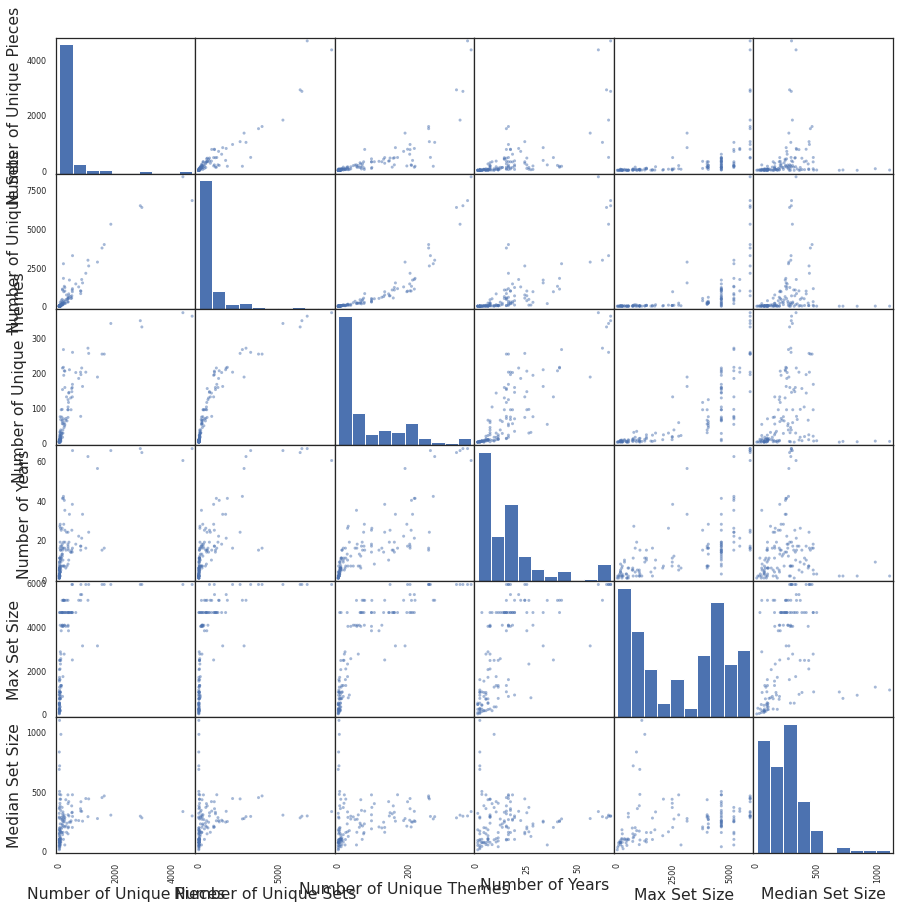

In [ ]:
_ = pd.plotting.scatter_matrix(lego_colors, figsize=(15,15))

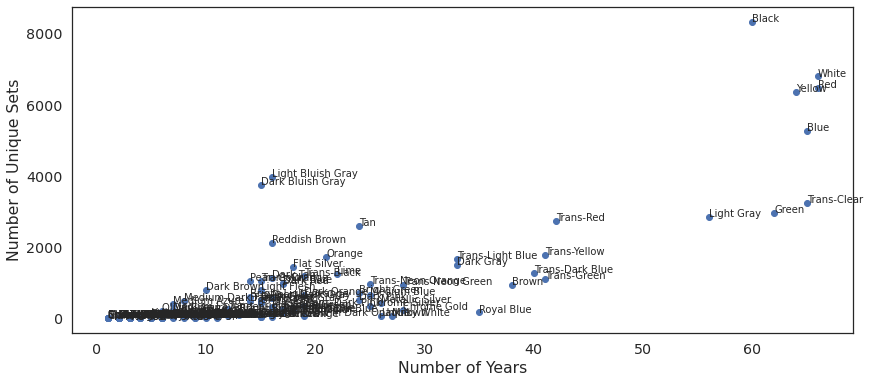

In [ ]:
# A quick plot of all the colors based on number of sets and years
plt.figure(figsize=(14,6))
plt.scatter(lego_colors["Number of Years"], lego_colors["Number of Unique Sets"])
plt.xlabel('Number of Years')
plt.ylabel('Number of Unique Sets')

for i, row in enumerate(lego_colors.values):
    plt.annotate(row[0],xy=(row[4],row[2]),fontsize=10)

**(File 2) LEGO Colors by Set** — Contains data on the colors of the pieces in each LEGO set.

- Set Num = A unique alphanumeric ID number for each set. 
- Set Name = The official name of the set (some names are reused for more than one set).
- Year = The year the set was released.
- Num Parts = Total number of parts listed on the box.
- Theme = The theme the set was released under ("Technic", "Ninjago", "Star Wars", "City", etc.)
- [Colors] = Number of parts of each color in the set, according to the Rebrickable database.

You can also get more data about individual sets by going to http://rebrickable.com/sets/{SetNum}

In [ ]:
# Import data, remove NaN
lego_colors_by_set_full = pd.read_excel('https://drive.google.com/uc?export=download&id=1EppL5Cy4YSND45x--HV3yKavszTu2ALB')
lego_colors_by_set_full.fillna(0, inplace=True)

# For this datathon we'll just focus on 10 of the most popular themes.
lego_colors_by_set = lego_colors_by_set_full[(lego_colors_by_set_full["Theme"] == "Technic") | 
                        (lego_colors_by_set_full["Theme"] == "Friends") |
                        (lego_colors_by_set_full["Theme"] == "City") |
                        (lego_colors_by_set_full["Theme"] == "Basic Set") |
                        (lego_colors_by_set_full["Theme"] == "Creator") |
                        (lego_colors_by_set_full["Theme"] == "Duplo") |
                        (lego_colors_by_set_full["Theme"] == "Star Wars") |
                        (lego_colors_by_set_full["Theme"] == "Ninjago") |
                        (lego_colors_by_set_full["Theme"] == "Construction") |
                        (lego_colors_by_set_full["Theme"] == "Airport")]

In [ ]:
lego_colors_by_set.head(3)

,Set Num,Set Name,Theme,Year,Num Parts,[No Color],Aqua,Black,Blue,Blue-Violet,...,Trans-Very Lt Blue,Trans-Yellow,Unknown,Very Light Bluish Gray,Very Light Gray,Very Light Orange,Violet,White,Yellow,Yellowish Green
4,2823692,Simple and Motorized Machines Activity Pack,Technic,1997,24,24.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2818944,Structures Set,Technic,1997,439,20.0,0.0,116.0,56.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2814926,Technology Activity Set,Technic,1994,318,17.0,0.0,92.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0


Some potentially useful refactorings of the data.

In [ ]:
# Creates a copy of the dataframe where color counts are normalized 
#  so each gives the % of parts in the set with that color, rather than the total count.
lego_colors_by_set_norm = lego_colors_by_set.copy()
lego_colors_by_set_norm = lego_colors_by_set_norm.drop([ 'Set Name', 'Set Num', 'Theme', 'Year', 'Num Parts'], axis=1)
lego_colors_by_set_norm = lego_colors_by_set_norm.div(lego_colors_by_set_norm.sum(axis=1), axis=0)

# A list of all the color name columns
color_cols = lego_colors_by_set_norm.columns
# A list of all the other numeric columns
other_cols = ["Year", "Num Parts"]

# Add back the non-numeric columns to the normalized table
lego_colors_by_set_norm["Year"] = lego_colors_by_set["Year"]
lego_colors_by_set_norm["Set Name"] = lego_colors_by_set["Set Name"]
lego_colors_by_set_norm["Set Num"] = lego_colors_by_set["Set Num"]
lego_colors_by_set_norm["Theme"] = lego_colors_by_set["Theme"]
lego_colors_by_set_norm["Num Parts"] = lego_colors_by_set["Num Parts"]
lego_colors_by_set_norm.head(3)

,[No Color],Aqua,Black,Blue,Blue-Violet,Bright Green,Bright Light Blue,Bright Light Orange,Bright Light Yellow,Bright Pink,...,Very Light Orange,Violet,White,Yellow,Yellowish Green,Year,Set Name,Set Num,Theme,Num Parts
4,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,1997,Simple and Motorized Machines Activity Pack,2823692,Technic,24
8,0.045558,0.0,0.264237,0.127563,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,1997,Structures Set,2818944,Technic,439
10,0.051360,0.0,0.277946,0.006042,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.006042,0.003021,0.0,1994,Technology Activity Set,2814926,Technic,318


In [ ]:
color_cols # The complete list of color columns

Index(['[No Color]', 'Aqua', 'Black', 'Blue', 'Blue-Violet', 'Bright Green',
       'Bright Light Blue', 'Bright Light Orange', 'Bright Light Yellow',
       'Bright Pink',
       ...
       'Trans-Very Lt Blue', 'Trans-Yellow', 'Unknown',
       'Very Light Bluish Gray', 'Very Light Gray', 'Very Light Orange',
       'Violet', 'White', 'Yellow', 'Yellowish Green'],
      dtype='object', length=131)

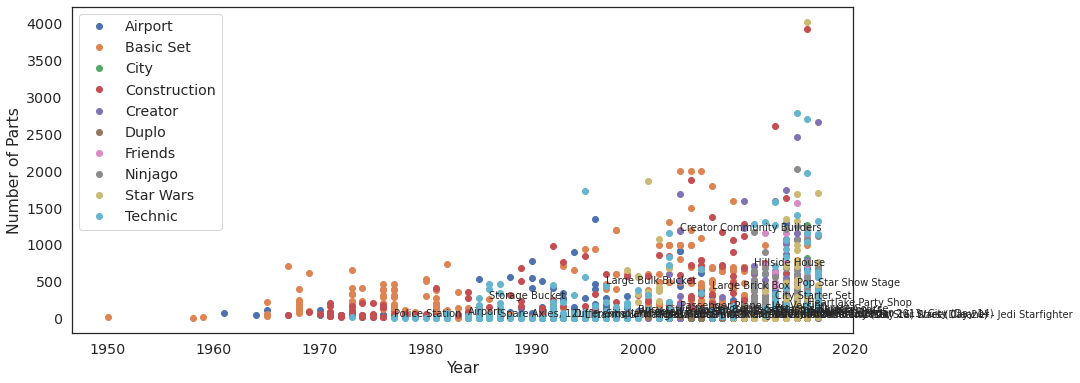

In [ ]:
# A quick plot of all the sets in our reduced dataset by number of parts and year
themes = lego_colors_by_set.groupby("Theme")
plt.figure(figsize=(14,6))
plt.xlabel('Year')
plt.ylabel('Number of Parts')

for theme, group in themes: # iterate and plot sets by theme for colors
    plt.plot(group["Year"], group["Num Parts"], marker="o", linestyle="", label=theme)
    for i, row in enumerate(group.values[0::100]): #add labels on every 100th set
        plt.annotate(row[1],xy=(row[3],row[4]),fontsize=10)

_ = plt.legend()



Remember that you can always export results to a CSV to examine them elsewhere (for example in Tableau).

In [ ]:
lego_colors_by_set.to_csv("lego_dataframe_export.csv")

## Questions

***Using File 1 (Lego Colors Data):***
1. Use *principle component analysis (PCA)* to find a projection that reveals groups of colors that have similar characteristics. What set of data columns and set of principle components do you think show the clearest result? 
2. Use *hierarchical clustering* to find groups of colors that have similar characteristics. What set of data columns, distance metric, linkage function, and distance threshold do you think give the best result?
3. Use *k-means* clustering to find groups of colors that have similar characteristics. What set of data columns and what value of k do you think gives the best result? 

***Using File 2 (Set Color Data):***

4. Train and test (**a**) a *kNN* classifier and (**b**) a *Naïve Bayes* classifier to predict the theme for new Lego kits based on the data about them.
    * For each classifier, report:
        * What parameters (if any) you tuned.
        * How well it performed. — Report the Accuracy, Precision, Recall, and F1-score. Also render a confusion matrix. (Remember, don’t test on your training data!)
        * Your interpretation of the result. Explain what you think the classifier got right/wrong. (Feel free to include visualizations or additional info that helps explain).

... + 1 more analysis questions of your own using either File 1 (Lego Colors) or File 2 (Lego Colors by Set) and the tool(s) of your choice.